# Easy OCR

Ready-to-use OCR with 80+ supported languages and all popular writing scripts including: Latin, Chinese, Arabic, Devanagari, Cyrillic, etc.

[API Documentation](https://www.jaided.ai/easyocr/documentation/)

Live Demo: [Link on Hugging Face](https://huggingface.co/spaces/tomofi/EasyOCR)

![image](https://raw.githubusercontent.com/JaidedAI/EasyOCR/master/examples/example.png)



### Install Libraries

In [16]:
# pip install easyocr
import easyocr
from IPython.display import Image

### Test Image

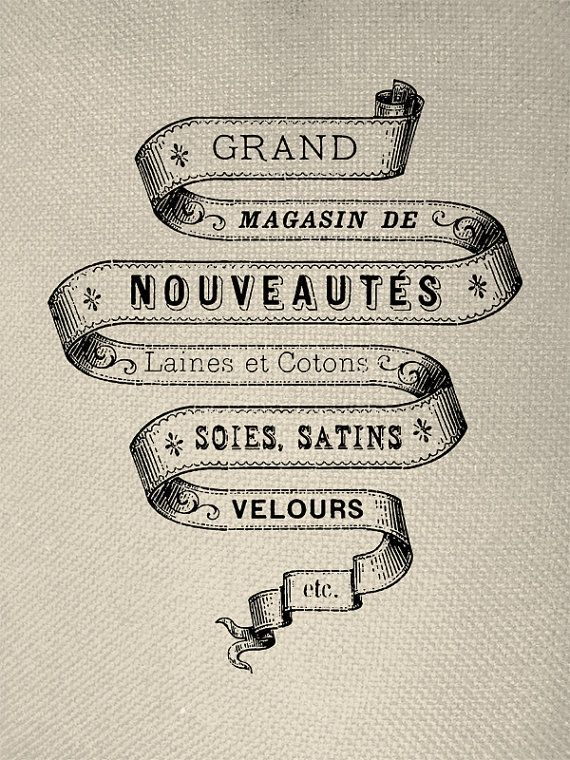

In [17]:
Image('/content/french_pic.jpg')

### Deriving Results

In [6]:
reader = easyocr.Reader(['fr','en']) # this needs to run only once to load the model into memory

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [7]:
result = reader.readtext('/content/french_pic.jpg')

In [19]:
result

[([[209, 129], [361, 129], [361, 167], [209, 167]],
  'GRAND',
  0.9999176858489582),
 ([[236, 206], [420, 206], [420, 234], [236, 234]],
  'MAGASIN DE',
  0.7263800115146478),
 ([[122, 262], [449, 262], [449, 322], [122, 322]],
  'NOUVEAUTÉS',
  0.41005660840347896),
 ([[464, 272], [490, 272], [490, 302], [464, 302]], '*', 0.8845667491189033),
 ([[139, 346], [375, 346], [375, 384], [139, 384]],
  'Laines et Cotons',
  0.9502632265940077),
 ([[189, 419], [409, 419], [409, 457], [189, 457]],
  'SOIES, SATINS',
  0.6589369729330351),
 ([[226, 491], [369, 491], [369, 527], [226, 527]],
  'VELOURS',
  0.6266805955800845),
 ([[298, 576], [336, 576], [336, 602], [298, 602]],
  'ctc',
  0.27897872680176883)]

The output is in a list format, each item represents a bounding box, the text detected and confident level, respectively.

In [20]:
# To extract only the text
reader.readtext('/content/french_pic.jpg', detail = 0)

['GRAND',
 'MAGASIN DE',
 'NOUVEAUTÉS',
 '*',
 'Laines et Cotons',
 'SOIES, SATINS',
 'VELOURS',
 'ctc']

## Now we can try to train our own models
[Link to Documentation](https://github.com/JaidedAI/EasyOCR/blob/master/custom_model.md)



In [21]:
import torch.nn as nn

class BidirectionalLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_size * 2, output_size)

    def forward(self, input):
        """
        input : visual feature [batch_size x T x input_size]
        output : contextual feature [batch_size x T x output_size]
        """
        try: # multi gpu needs this
            self.rnn.flatten_parameters()
        except: # quantization doesn't work with this
            pass
        recurrent, _ = self.rnn(input)  # batch_size x T x input_size -> batch_size x T x (2*hidden_size)
        output = self.linear(recurrent)  # batch_size x T x output_size
        return output

class VGG_FeatureExtractor(nn.Module):

    def __init__(self, input_channel, output_channel=256):
        super(VGG_FeatureExtractor, self).__init__()
        self.output_channel = [int(output_channel / 8), int(output_channel / 4),
                               int(output_channel / 2), output_channel]
        self.ConvNet = nn.Sequential(
            nn.Conv2d(input_channel, self.output_channel[0], 3, 1, 1), nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(self.output_channel[0], self.output_channel[1], 3, 1, 1), nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(self.output_channel[1], self.output_channel[2], 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(self.output_channel[2], self.output_channel[2], 3, 1, 1), nn.ReLU(True),
            nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(self.output_channel[2], self.output_channel[3], 3, 1, 1, bias=False),
            nn.BatchNorm2d(self.output_channel[3]), nn.ReLU(True),
            nn.Conv2d(self.output_channel[3], self.output_channel[3], 3, 1, 1, bias=False),
            nn.BatchNorm2d(self.output_channel[3]), nn.ReLU(True),
            nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(self.output_channel[3], self.output_channel[3], 2, 1, 0), nn.ReLU(True))

    def forward(self, input):
        return self.ConvNet(input)

class Model(nn.Module):

    def __init__(self, input_channel, output_channel, hidden_size, num_class):
        super(Model, self).__init__()
        """ FeatureExtraction """
        self.FeatureExtraction = VGG_FeatureExtractor(input_channel, output_channel)
        self.FeatureExtraction_output = output_channel
        self.AdaptiveAvgPool = nn.AdaptiveAvgPool2d((None, 1))

        """ Sequence modeling"""
        self.SequenceModeling = nn.Sequential(
            BidirectionalLSTM(self.FeatureExtraction_output, hidden_size, hidden_size),
            BidirectionalLSTM(hidden_size, hidden_size, hidden_size))
        self.SequenceModeling_output = hidden_size

        """ Prediction """
        self.Prediction = nn.Linear(self.SequenceModeling_output, num_class)


    def forward(self, input, text):
        """ Feature extraction stage """
        visual_feature = self.FeatureExtraction(input)
        visual_feature = self.AdaptiveAvgPool(visual_feature.permute(0, 3, 1, 2))
        visual_feature = visual_feature.squeeze(3)

        """ Sequence modeling stage """
        contextual_feature = self.SequenceModeling(visual_feature)

        """ Prediction stage """
        prediction = self.Prediction(contextual_feature.contiguous())

        return prediction


network_params:

*  input_channel: 1
*  output_channel: 256
*  hidden_size: 256

imgH: 64

lang_list: 'en'

character_list:

- 0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ €ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
